## DNSC Data Mining Semester Project

### DonorsChoose.org Application Screening from Kaggle
https://www.kaggle.com/c/donorschoose-application-screening

Group Members:
* Pei-Hsuan Hsia
* Agnes Jiang
* Guangyu Xing

In [2]:
import pandas as pd
import datetime as dt
import numpy as np

#LabelEncoder
from sklearn.preprocessing import LabelEncoder

#TD-IDF
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

#Models
#from __future__ import division
import lightgbm as lgb
from sklearn import cross_validation, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#RandomizedSearchCV, GridSearchCV

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
pd.set_option('display.max_columns', None) 

In [4]:
train = pd.read_csv('D:\\2018Spring\\Data Mining\\final_project\\train.csv').fillna('')
test = pd.read_csv('D:\\2018Spring\\Data Mining\\final_project\\test.csv').fillna('')

C:\Users\USER\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
train.columns

Index(['id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')

In [6]:
train.shape

(182080, 16)

### Extracting information from Resource Dataset

In [7]:
resource = pd.read_csv("D:\\2018Spring\\Data Mining\\final_project\\resources.csv").fillna(' ')
resource.head()

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


In [8]:
# Aggregate and Merge
resource['sum_price'] = resource['quantity'] * resource['price']
agg_resource = resource.groupby(['id']).agg(
    dict(quantity = ['sum',"mean"],
         price = ["max","min","std"],
         sum_price = ["sum"],
         id = 'count',
         description = lambda x: ' '.join(x))).reset_index()
agg_resource.columns = pd.Index([e[0] +"_"+ e[1] for e in agg_resource.columns.tolist()]) # Collapse Multi-index
agg_resource["price_avg"] = round(agg_resource["sum_price_sum"] / agg_resource["quantity_sum"], 2)

In [9]:
agg_resource.rename(columns = {'id_': "id", 'sum_price_sum':"price_sum", 'id_count':"count", 'description_<lambda>': "description"}, inplace=True)
agg_resource.price_std.fillna(0, inplace=True)

In [10]:
agg_resource.head()

,id,quantity_sum,quantity_mean,price_max,price_min,price_std,price_sum,count,description,price_avg
0,p000001,7,1.750000,261.08,23.99,101.929679,833.63,4,"Cap Barbell 300 Pound Olympic Set, Grey Cap Ba...",119.09
1,p000002,21,1.500000,134.90,8.46,33.549557,630.28,14,10 Sony Headphones (BUY 9 GET 1 FREE) Belkin 6...,30.01
2,p000003,4,1.000000,169.00,39.99,63.014906,298.97,4,EE820X - Phonemic Awareness Instant Learning C...,74.74
3,p000004,98,1.031579,401.54,1.60,40.608577,1126.22,95,A Bad Case of the Giggles Poems That Will Make...,11.49
4,p000005,8,2.000000,323.75,54.08,134.835000,702.31,4,"Fitbit Zip Wireless Activity Tracker, Lime Fit...",87.79


In [11]:
#Merge
train1 = pd.merge(train, agg_resource, how = 'left', on = 'id')
test1 = pd.merge(test, agg_resource, how = 'left', on = 'id')

### Calculate the approved rate within 7 days for every project submitted date - 'approve_rate_7d'

In [12]:
train1['project_submitted_datetime'] = pd.to_datetime(train1['project_submitted_datetime'])
test1['project_submitted_datetime'] = pd.to_datetime(test1['project_submitted_datetime'])

In [13]:
train1['date'] = train1['project_submitted_datetime'].dt.date
test1['date'] = test1['project_submitted_datetime'].dt.date

In [14]:
counts_submit = train1.groupby('date').size().reset_index(name = 'counts_submit')
counts_approve = train1.loc[train1['project_is_approved'] == 1] \
                 .groupby('date').size().reset_index(name = 'counts_approve')

In [15]:
counts_proposal = pd.merge(counts_submit, counts_approve, on = 'date')

In [16]:
counts_proposal['time_range_end'] = counts_proposal['date']
counts_proposal['time_range_start'] = counts_proposal['time_range_end'] - pd.to_timedelta(7, unit = 'D')

In [17]:
counts_proposal['approve_rate_7d'] = ""

In [18]:
%%time
for i in range(counts_proposal.index.max()):
    subset = counts_proposal.loc[(counts_proposal['date'] >= counts_proposal.loc[i, 'time_range_start']) \
                             & (counts_proposal['date'] <= counts_proposal.loc[i, 'time_range_end']), ['counts_submit','counts_approve']]
    counts_proposal.loc[i, 'approve_rate_7d'] = subset['counts_approve'].sum() / subset['counts_submit'].sum()

Wall time: 1.43 s


In [19]:
counts_7d = counts_proposal[['date', 'approve_rate_7d']]

In [20]:
train2 = pd.merge(train1, counts_7d, on = 'date')
test2 = pd.merge(test1, counts_7d, on = 'date')
train2.drop(['date'], axis = 1, inplace = True)
test2.drop(['date'], axis = 1, inplace = True)

### Text counts

In [21]:
train2["essays_combined"] = train2["project_essay_1"] + train2["project_essay_2"]  \
                         + train2["project_essay_3"] + train2["project_essay_4"]

In [22]:
text_col = ["essays_combined","project_resource_summary", "description"]
for col in text_col:
    train2[col] = train2[col].astype(str)
    train2[col] = train2[col].str.lower()
    train2[col+'_n_chars'] = train2[col].apply(len) # Count number of Characters
    train2[col+'_n_words'] = train2[col].apply(lambda x: len(x.split())) # Count number of Words
    train2[col+'_n_uniq_words'] = train2[col].apply(lambda x: len(set(w for w in x.split()))) # Count Unique Words
    train2[col+'_words_vs_unique'] = train2[col+'_n_uniq_words'] / train2[col+'_n_words']*100  # Unique words to Word count Ratio

In [23]:
train2.drop(["project_essay_1", "project_essay_2", "project_essay_3",
              "project_essay_4"], inplace = True, axis = 1)

In [24]:
test2["essays_combined"] = test2["project_essay_1"] + test2["project_essay_2"]  \
                         + test2["project_essay_3"] + test2["project_essay_4"]

In [25]:
for col in text_col:
    test2[col] = test2[col].astype(str)
    test2[col] = test2[col].str.lower()
    test2[col+'_n_chars'] = test2[col].apply(len)
    test2[col+'_n_words'] = test2[col].apply(lambda x: len(x.split()))
    test2[col+'_n_uniq_words'] = test2[col].apply(lambda x: len(set(w for w in x.split())))
    test2[col+'_words_vs_unique'] = test2[col+'_n_uniq_words'] / test2[col+'_n_words']*100

In [26]:
test2.drop(["project_essay_1", "project_essay_2", "project_essay_3",
              "project_essay_4"], inplace = True, axis = 1)

### Labor Encoding for Text Columns

In [27]:
encoding_col = ["project_grade_category", "project_subject_categories",
             "school_state", "teacher_prefix"]

In [28]:
for col in encoding_col:
    le = LabelEncoder()
    le.fit(train2[col])
    train2[col] = le.transform(train2[col])
    test2[col] = le.transform(test2[col])

In [29]:
train2.columns

Index(['id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'quantity_sum', 'quantity_mean', 'price_max', 'price_min', 'price_std',
       'price_sum', 'count', 'description', 'price_avg', 'approve_rate_7d',
       'essays_combined', 'essays_combined_n_chars', 'essays_combined_n_words',
       'essays_combined_n_uniq_words', 'essays_combined_words_vs_unique',
       'project_resource_summary_n_chars', 'project_resource_summary_n_words',
       'project_resource_summary_n_uniq_words',
       'project_resource_summary_words_vs_unique', 'description_n_chars',
       'description_n_words', 'description_n_uniq_words',
       'description_words_vs_unique'],
      dtype='object')

### Sentiment analysis

In [31]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
SIA = SentimentIntensityAnalyzer()

C:\Users\USER\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [32]:
dataset = [train2, test2]
for data in dataset:
    data['compound'] = 0
    data['neg'] = 0
    data['neu'] = 0
    data['pos'] = 0
    for i in range(data.shape[0]):
        ss = SIA.polarity_scores(data.loc[i, 'essays_combined'])    
        for k in sorted(ss):
            data.loc[i, k] = ss[k]

In [33]:
#train2[['id,'compound','neg','neu','pos']].to_csv('train_sentiment.csv', index = False)

In [34]:
#test2[['id','compound','neg','neu','pos']].to_csv('test_sentiment.csv', index = False)

In [30]:
train_sentiment = pd.read_csv('train_sentiment.csv')
test_sentiment = pd.read_csv('test_sentiment.csv')

In [31]:
train2 = pd.merge(train2, train_sentiment, on = 'id')
test2 = pd.merge(test2, test_sentiment, on = 'id')

## TF-IDF

In [32]:
%%time
cols = ["essays_combined", "project_resource_summary", "project_title", "description"]
n_features = [10000, 1000, 400, 1000]

for c_i, c in tqdm(enumerate(cols)):
    tfidf = TfidfVectorizer(max_features=n_features[c_i], min_df=3)
    tfidf.fit(train2[c])
    tfidf_train = np.array(tfidf.transform(train2[c]).todense(), dtype=np.float16)
    tfidf_test = np.array(tfidf.transform(test2[c]).todense(), dtype=np.float16)

    for i in range(n_features[c_i]):
        train2[c + '_tfidf_' + str(i)] = tfidf_train[:, i]
        test2[c + '_tfidf_' + str(i)] = tfidf_test[:, i]        

4it [17:27, 261.84s/it]


Wall time: 17min 27s


In [33]:
train2.shape

(182080, 12439)

### Models: LGBM + Logistics Regression

#### Light GBM

In [35]:
train_model = train2.drop(['id', 'project_submitted_datetime', 'approve_rate_7d', 'teacher_id', 'project_subject_subcategories',
       'project_title', 'project_resource_summary', 'description','essays_combined', "project_is_approved"], axis = 1)
test_model = test2.drop(['id', 'project_submitted_datetime', 'approve_rate_7d','teacher_id', 'project_subject_subcategories',
       'project_title', 'project_resource_summary', 'description','essays_combined'], axis = 1)

In [36]:
y = train2["project_is_approved"].copy()

In [37]:
X_train, X_valid, y_train, y_valid = train_test_split(train_model, y, test_size=0.3, random_state=23)

In [38]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

In [39]:
params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': {'binary_logloss'}, 'num_leaves': 63,
          'num_trees': 100, 'learning_rate': 0.01, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5,
          'verbose': 0}
num_leaf = 63

In [40]:
%%time
gbm = lgb.train(params, lgb_train, num_boost_round = 100, valid_sets = lgb_eval)

C:\Users\USER\Anaconda3\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's binary_logloss: 0.687863
[2]	valid_0's binary_logloss: 0.682713
[3]	valid_0's binary_logloss: 0.677646
[4]	valid_0's binary_logloss: 0.672676
[5]	valid_0's binary_logloss: 0.667794
[6]	valid_0's binary_logloss: 0.663024
[7]	valid_0's binary_logloss: 0.658342
[8]	valid_0's binary_logloss: 0.653765
[9]	valid_0's binary_logloss: 0.649256
[10]	valid_0's binary_logloss: 0.644834
[11]	valid_0's binary_logloss: 0.640511
[12]	valid_0's binary_logloss: 0.636269
[13]	valid_0's binary_logloss: 0.632096
[14]	valid_0's binary_logloss: 0.628011
[15]	valid_0's binary_logloss: 0.624005
[16]	valid_0's binary_logloss: 0.620052
[17]	valid_0's binary_logloss: 0.616174
[18]	valid_0's binary_logloss: 0.612369
[19]	valid_0's binary_logloss: 0.608633
[20]	valid_0's binary_logloss: 0.604981
[21]	valid_0's binary_logloss: 0.60136
[22]	valid_0's binary_logloss: 0.59781
[23]	valid_0's binary_logloss: 0.59433
[24]	valid_0's binary_logloss: 0.590907
[25]	valid_0's binary_logloss: 0.587542
[26]	valid_0

In [41]:
y_pred = gbm.predict(X_train,pred_leaf=True)
y_pred_valid = gbm.predict(X_valid,pred_leaf=True)
y_pred_test = gbm.predict(test_model,pred_leaf=True)

In [42]:
transformed_training_matrix = np.zeros([len(y_pred),len(y_pred[0]) * num_leaf],dtype=np.int64)
for i in range(0, len(y_pred)):
    temp = np.arange(len(y_pred[0])) * num_leaf - 1 + np.array(y_pred[i])
    transformed_training_matrix[i][temp] += 1

In [43]:
transformed_training_matrix_valid = np.zeros([len(y_pred_valid),len(y_pred_valid[0]) * num_leaf],dtype=np.int64)
for i in range(0, len(y_pred_valid)):
    temp = np.arange(len(y_pred_valid[0])) * num_leaf - 1 + np.array(y_pred_valid[i])
    transformed_training_matrix_valid[i][temp] += 1

In [44]:
transformed_training_matrix_test = np.zeros([len(y_pred_test),len(y_pred_test[0]) * num_leaf],dtype=np.int64)
for i in range(0, len(y_pred_test)):
    temp = np.arange(len(y_pred_test[0])) * num_leaf - 1 + np.array(y_pred_test[i])
    transformed_training_matrix_test[i][temp] += 1

#### Logistics Regression

In [45]:
c = np.array([1,0.5,0.1,0.05,0.01,0.005,0.001])
for t in range(0,len(c)):
    lm = LogisticRegression(penalty='l2',C=c[t]) # logestic model construction
    lm.fit(transformed_training_matrix, y_train)

In [46]:
y_pred_est = lm.predict_proba(transformed_training_matrix)
y_pred_est_valid = lm.predict_proba(transformed_training_matrix_valid)
y_pred_est_test = lm.predict_proba(transformed_training_matrix_test)

In [47]:
pred = pd.DataFrame(y_pred_est)
pred_train = pred[1]

pred = pd.DataFrame(y_pred_est_valid)
pred_valid = pred[1]

pred = pd.DataFrame(y_pred_est_test)
pred_test = pred[1]

In [48]:
train_auc = metrics.roc_auc_score(y_train, pred_train)
train_auc

0.77827746817719312

In [49]:
valid_auc = metrics.roc_auc_score(y_valid, pred_valid)
valid_auc

0.74496744457697872

In [50]:
submission = pd.DataFrame()
submission['id'] = test2['id']
submission['project_is_approved'] = pred_test
submission = submission.set_index('id')
submission.to_csv('submission.csv')

The final score on Kaggle is shown below.

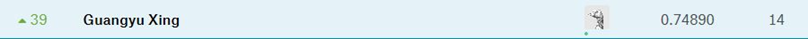